In [5]:
#!pip install wordcloud

In [6]:
# LIBRARY HUB

import numpy as np
import pandas as pd
import json
import datetime

import re
import nltk
from nltk.corpus import stopwords

from collections import Counter

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud


## CHANNEL DATA

In [7]:
df = pd.read_csv('Channel-Video/Youtube_channel_data.csv')
df.head(2)

,Unnamed: 0,channel_id,channel_name,Subscribers,Viewers,Videos_made,HiddenSubCount,channel_start,kind,channel_description
0,0,UCppHT7SZKKvar4Oc9J4oljQ,Zee TV,72500000,7.649366e+10,134822,False,2005-12-11T06:23:26Z,youtube#channel,"Launched in 1992, ZEE TV is the pioneer of tel..."
1,1,UCq-Fj5jknLsUf-MWSy4_brA,T-Series,249000000,2.328870e+11,19492,False,2006-03-13T14:27:05Z,youtube#channel,"""Music can change the world"". T-Series is Indi..."


In [8]:
df.shape

(4334, 10)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,4334.0,2.166500e+03,1.251262e+03,0.0,1.083250e+03,2.166500e+03,3.249750e+03,4.333000e+03
Subscribers,4334.0,7.164155e+06,1.200408e+07,2.0,1.640000e+06,3.990000e+06,8.395000e+06,2.490000e+08
Viewers,4334.0,3.874322e+09,9.173059e+09,0.0,6.097440e+08,1.887103e+09,4.058983e+09,2.328870e+11
Videos_made,4334.0,8.725539e+03,3.587469e+04,0.0,2.420000e+02,9.170000e+02,3.007000e+03,7.051850e+05


### DATA CLEANING

In [10]:
# Dropping the first column 'Unnanmed: 0'
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   channel_id           4334 non-null   object 
 1   channel_name         4334 non-null   object 
 2   Subscribers          4334 non-null   int64  
 3   Viewers              4334 non-null   float64
 4   Videos_made          4334 non-null   int64  
 5   HiddenSubCount       4334 non-null   bool   
 6   channel_start        4334 non-null   object 
 7   kind                 4334 non-null   object 
 8   channel_description  3962 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(5)
memory usage: 275.2+ KB


In [12]:
# Splitting channel_start column to datetime columns
# Converting the data type to Datetime
df['channel_start'] = pd.to_datetime(df['channel_start'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   channel_id           4334 non-null   object             
 1   channel_name         4334 non-null   object             
 2   Subscribers          4334 non-null   int64              
 3   Viewers              4334 non-null   float64            
 4   Videos_made          4334 non-null   int64              
 5   HiddenSubCount       4334 non-null   bool               
 6   channel_start        4334 non-null   datetime64[ns, UTC]
 7   kind                 4334 non-null   object             
 8   channel_description  3962 non-null   object             
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(2), object(4)
memory usage: 275.2+ KB


In [13]:
# Create new columns for year, month, day, and time
df['start_year'] = df['channel_start'].dt.year
df['start_month'] = df['channel_start'].dt.month
df['start_day'] = df['channel_start'].dt.day
df['start_time'] = df['channel_start'].dt.strftime('%H:%M:%S')
#df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   channel_id           4334 non-null   object             
 1   channel_name         4334 non-null   object             
 2   Subscribers          4334 non-null   int64              
 3   Viewers              4334 non-null   float64            
 4   Videos_made          4334 non-null   int64              
 5   HiddenSubCount       4334 non-null   bool               
 6   channel_start        4334 non-null   datetime64[ns, UTC]
 7   kind                 4334 non-null   object             
 8   channel_description  3962 non-null   object             
 9   start_year           4334 non-null   int32              
 10  start_month          4334 non-null   int32              
 11  start_day            4334 non-null   int32              
 12  start_time          

,channel_id,channel_name,Subscribers,Viewers,Videos_made,HiddenSubCount,channel_start,kind,channel_description,start_year,start_month,start_day,start_time
0,UCppHT7SZKKvar4Oc9J4oljQ,Zee TV,72500000,7.649366e+10,134822,False,2005-12-11 06:23:26+00:00,youtube#channel,"Launched in 1992, ZEE TV is the pioneer of tel...",2005,12,11,06:23:26
1,UCq-Fj5jknLsUf-MWSy4_brA,T-Series,249000000,2.328870e+11,19492,False,2006-03-13 14:27:05+00:00,youtube#channel,"""Music can change the world"". T-Series is Indi...",2006,3,13,14:27:05


In [14]:
# Split the 'time' column into hours, minutes, and seconds
df[['start_hour', 'start_minute', 'start_second']] = df['start_time'].str.split(':', expand=True)

In [15]:
df.head(2)

,channel_id,channel_name,Subscribers,Viewers,Videos_made,HiddenSubCount,channel_start,kind,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second
0,UCppHT7SZKKvar4Oc9J4oljQ,Zee TV,72500000,7.649366e+10,134822,False,2005-12-11 06:23:26+00:00,youtube#channel,"Launched in 1992, ZEE TV is the pioneer of tel...",2005,12,11,06:23:26,06,23,26
1,UCq-Fj5jknLsUf-MWSy4_brA,T-Series,249000000,2.328870e+11,19492,False,2006-03-13 14:27:05+00:00,youtube#channel,"""Music can change the world"". T-Series is Indi...",2006,3,13,14:27:05,14,27,05


In [16]:
print(df['kind'].unique())
print(df['HiddenSubCount'].unique())

['youtube#channel']
[False]


In [17]:
df.drop(['channel_id', 'channel_start', 'kind', 'HiddenSubCount'], axis = 1, inplace = True)
df.head(2)

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second
0,Zee TV,72500000,7.649366e+10,134822,"Launched in 1992, ZEE TV is the pioneer of tel...",2005,12,11,06:23:26,06,23,26
1,T-Series,249000000,2.328870e+11,19492,"""Music can change the world"". T-Series is Indi...",2006,3,13,14:27:05,14,27,05


In [18]:
df[['Viewers']]

,Viewers
0,7.649366e+10
1,2.328870e+11
2,1.682480e+11
3,1.517180e+11
4,7.877977e+10
...,...
4329,2.834100e+05
4330,2.087983e+09
4331,0.000000e+00
4332,1.968355e+09


In [19]:
df[['channel_name','Viewers']]

,channel_name,Viewers
0,Zee TV,7.649366e+10
1,T-Series,2.328870e+11
2,Cocomelon - Nursery Rhymes,1.682480e+11
3,SET India,1.517180e+11
4,WWE,7.877977e+10
...,...,...
4329,Daniel Shaya,2.834100e+05
4330,Mythri Movie Makers,2.087983e+09
4331,Machinima,0.000000e+00
4332,luisitorey,1.968355e+09


In [20]:
df.head(2)

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second
0,Zee TV,72500000,7.649366e+10,134822,"Launched in 1992, ZEE TV is the pioneer of tel...",2005,12,11,06:23:26,06,23,26
1,T-Series,249000000,2.328870e+11,19492,"""Music can change the world"". T-Series is Indi...",2006,3,13,14:27:05,14,27,05


### EDA

In [21]:
# High - Low cubscriber count

print(f'Min Subscribers: {df.loc[df["Subscribers"].idxmin(), "Subscribers"]} -> Channel Name: {df.loc[df["Subscribers"].idxmin(), "channel_name"]}')

print(f'Max Subscribers: {df.loc[df["Subscribers"].idxmax(), "Subscribers"]} -> Channel Name: {df.loc[df["Subscribers"].idxmax(), "channel_name"]}')

Min Subscribers: 2 -> Channel Name: Gơ over
Max Subscribers: 249000000 -> Channel Name: T-Series


In [22]:
df[df["channel_name"] == 'Gơ over']

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second
2993,Gơ over,2,366.0,7,NaN,2016,12,22,01:13:24,01,13,24


In [23]:
# Highest and lowest video count

print(f'Lowest count: {df.loc[df["Videos_made"].idxmin(), "Videos_made"]} -> Channel Name: {df.loc[df["Videos_made"].idxmin(), "Videos_made"]}')

print(f'Highest count: {df.loc[df["Videos_made"].idxmax(), "Videos_made"]} -> Channel Name: {df.loc[df["Videos_made"].idxmax(), "Videos_made"]}')

Lowest count: 0 -> Channel Name: 0
Highest count: 705185 -> Channel Name: 705185


In [24]:
df[df["Videos_made"] == df["Videos_made"].min()]
#df[df["Videos_made"] == df["Videos_made"].max()]

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second
89,hairong zheng,2020,0.0,0,NaN,2018,5,25,12:36:08,12,36,08
93,NollywoodStreams,4520000,0.0,0,Nollywood Streams is your #1 point for excitin...,2013,3,5,11:44:04,11,44,04
144,Family GamesTV,20200000,0.0,0,NaN,2016,1,26,13:57:22,13,57,22
506,Wit Vlogs,215000,0.0,0,"Hi everyone,\n\nNice to see you visit our page...",2017,8,19,03:12:06,03,12,06
696,Tatyane Sena,354000,0.0,0,NaN,2014,9,1,01:45:43,01,45,43
...,...,...,...,...,...,...,...,...,...,...,...,...
4109,Bublik,2290000,0.0,0,NaN,2015,11,4,05:08:37,05,08,37
4152,The Evans,118000,0.0,0,Stan Bangtan and ENHYPEN💜🧡,2014,8,2,20:03:32,20,03,32
4184,Antique Strings (Muse Tone Concert Hall ),380000,58028.0,0,NaN,2017,6,26,15:26:12,15,26,12
4230,The Jeremy Kyle Show,1500000,0.0,0,NaN,2015,1,26,15:11:28,15,11,28


It can be observed that a lot of channels are active but have 0 videos uploaded. 

In [25]:
df[df["Videos_made"] == df["Videos_made"].max()]

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second
1074,YTN,4100000,1.171641e+10,705185,24시간 생중계되는 대한민국 대표 뉴스\nYTN 공식채널을 지금 바로 구독하세요\n...,2013,5,23,07:07:42,07,07,42


The channel 'YTN' holds the record for the highest number of videos ever uploaded, with a total of 705,185 videos.

In [26]:
df.isna().sum()

channel_name             0
Subscribers              0
Viewers                  0
Videos_made              0
channel_description    372
start_year               0
start_month              0
start_day                0
start_time               0
start_hour               0
start_minute             0
start_second             0
dtype: int64

### TEXT ANALYSIS

In [27]:
df[df['channel_description'].isna()]

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second
18,Badabun,47000000,1.949811e+10,18957,NaN,2014,10,14,00:15:54,00,15,54
30,Like Nastya Show,42500000,1.971113e+10,633,NaN,2017,11,14,14:56:43,14,56,43
38,GMA Network,32800000,2.426162e+10,109118,NaN,2006,11,20,08:10:55,08,10,55
45,GR6 EXPLODE,39200000,2.560995e+10,3065,NaN,2014,8,5,05:21:03,05,21,03
61,Ed Sheeran - Topic,566000,2.968885e+09,729,NaN,2013,7,3,16:09:35,16,09,35
...,...,...,...,...,...,...,...,...,...,...,...,...
4289,MDP Digital,2440,1.599173e+06,4,NaN,2016,12,9,12:39:05,12,39,05
4299,okonomi monjya,140000,1.377510e+08,64,NaN,2014,5,15,18:27:52,18,27,52
4302,VAST Studio,3620000,5.946319e+08,745,NaN,2015,12,12,02:29:22,02,29,22
4305,Revolución Popular Noticias,711000,4.852327e+08,25801,NaN,2017,3,29,16:10:26,16,10,26


In text analysis, it is essential to remove these records as they do not contain any character data.

In [28]:
def clean_title(title):
    
    # Replace punctuation with space
    title = re.sub(r'[,.;@#?!&$\-\']+', ' ', str(title), flags=re.IGNORECASE)
    title = re.sub(' +', ' ', str(title), flags=re.IGNORECASE)
    title = re.sub(r'\"', ' ', str(title), flags=re.IGNORECASE)
    
    # Remove characters that are not a-z or A-Z
    title = re.sub(r'[^a-zA-Z]', ' ', str(title), flags=re.VERBOSE)
    
    # Remove commas and extra spaces
    title = title.replace(',', '')
    title = ' '.join(title.split())
    
    # Remove newline and carriage return characters
    title = re.sub("\n|\r", "", title)
    
    return title

df['channel_description_cleaned'] = df['channel_description'].apply(clean_title)

In [29]:
df[['channel_description_cleaned', 'channel_description']]

,channel_description_cleaned,channel_description
0,Launched in ZEE TV is the pioneer of televisio...,"Launched in 1992, ZEE TV is the pioneer of tel..."
1,Music can change the world T Series is India s...,"""Music can change the world"". T-Series is Indi..."
2,At CoComelon our primary goal has always been ...,"At CoComelon, our primary goal has always been..."
3,Sony Entertainment Television is one of the le...,Sony Entertainment Television is one of the le...
4,WWE on YouTube is your number one spot to catc...,WWE on YouTube is your number one spot to catc...
...,...,...
4329,I am Daniel SHAYA Instagram DanielShaya,Канал для взрослых детей 😜 I am Daniel SHAYA.\...
4330,Mythri Movie Makers is a popular Telugu movie ...,Mythri Movie Makers is a popular Telugu movie ...
4331,Machinima is the most notorious purveyor and c...,Machinima is the most notorious purveyor and c...
4332,En este canal hacemos un critica seria a los t...,En este canal hacemos un critica seria a los t...


In [30]:
# Word counter

cnt = Counter()

# Finding the occurence of words in video titles
for title in df['channel_description_cleaned']:
    for token in title.split():
        cnt[token] += 1

# Finding the 50 most used words in video titles
dist = cnt.most_common(50)
top_words = []
freqs = []
for word, freq in dist:
    top_words.append(word)
    freqs.append(freq)

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype

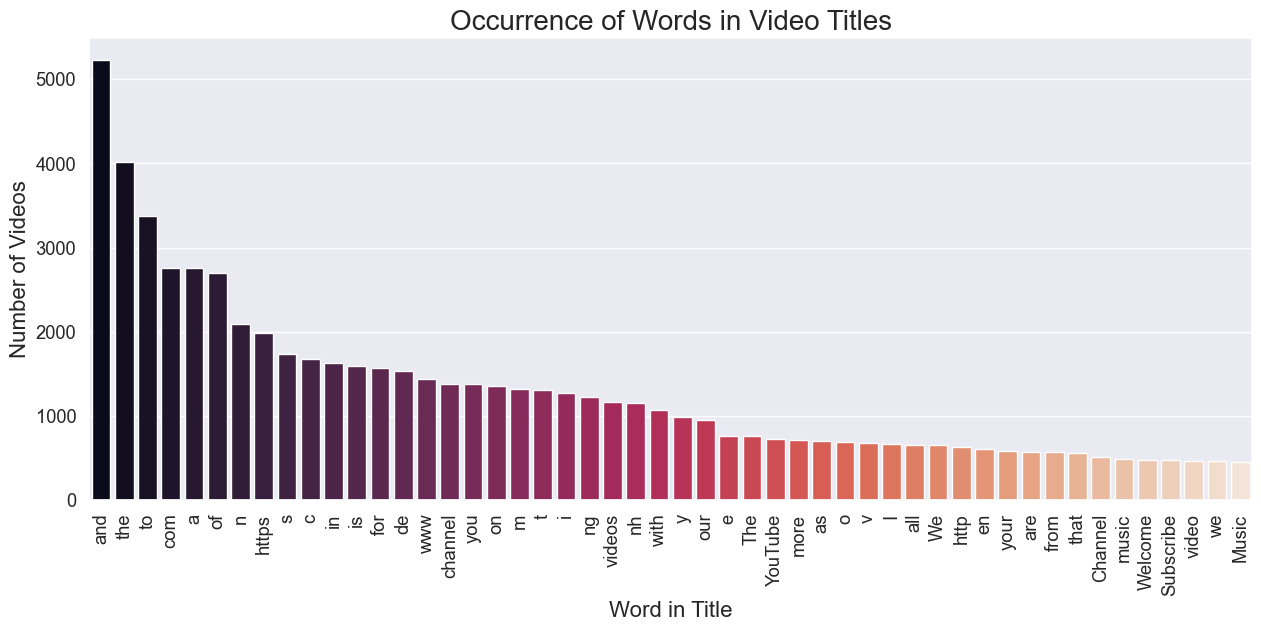

In [31]:
# Graphing number of times the world occure in title
fig= plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

sns.barplot(x=top_words,y=freqs, palette="rocket")

plt.xticks(rotation=90)
plt.xlabel('Word in Title', fontsize=16)
plt.ylabel('Number of Videos', fontsize=16)
plt.title('Occurrence of Words in Video Titles', fontsize=20)
plt.show()

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
# Define a function to remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the remove_stopwords function to the 'cleaned_title' column
df['channel_description_cleaned_ns'] = df['channel_description_cleaned'].apply(remove_stopwords)

In [34]:
cnt = Counter()

# Finding the occurence of words in video titles
for title in df['channel_description_cleaned_ns']:
    for token in title.split():
        cnt[token] += 1

# Finding the 50 most used words in video titles
dist = cnt.most_common(50)
top_words = []
freqs = []
for word, freq in dist:
    top_words.append(word)
    freqs.append(freq)

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype

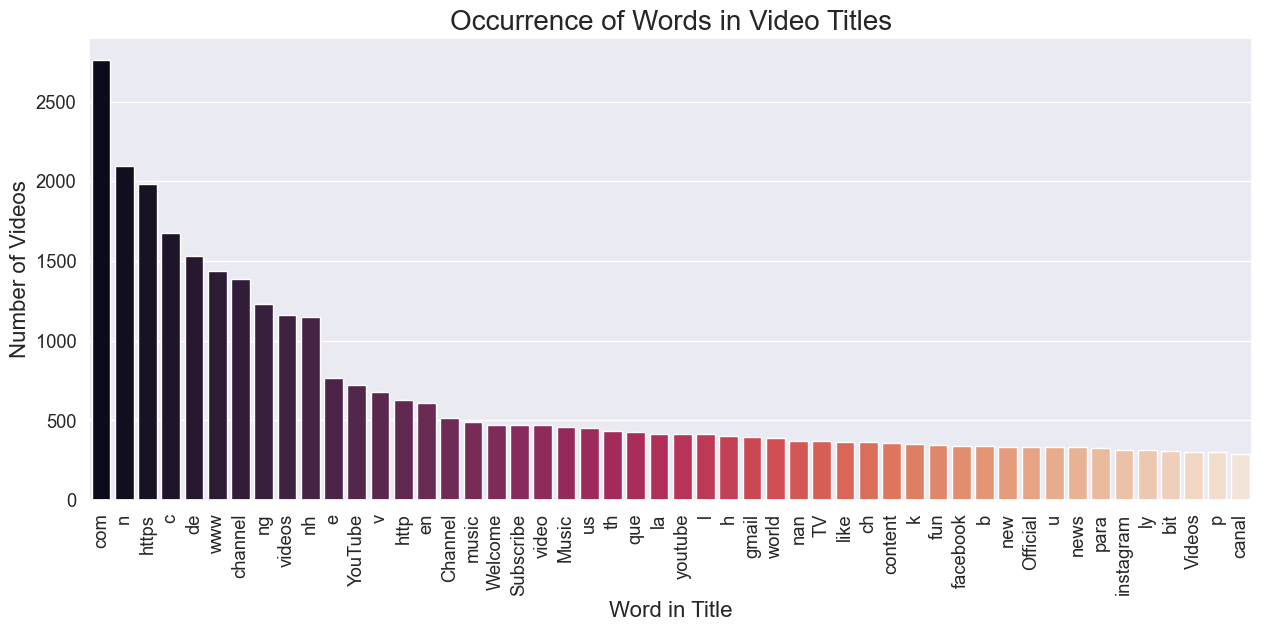

In [35]:
# Graphing number of times the world occure in title
fig= plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

sns.barplot(x=top_words,y=freqs, palette="rocket")

plt.xticks(rotation=90)
plt.xlabel('Word in Title', fontsize=16)
plt.ylabel('Number of Videos', fontsize=16)
plt.title('Occurrence of Words in Video Titles', fontsize=20)
plt.show()

In [36]:
df[['channel_description', 'channel_description_cleaned_ns', 'channel_description_cleaned']]

,channel_description,channel_description_cleaned_ns,channel_description_cleaned
0,"Launched in 1992, ZEE TV is the pioneer of tel...",Launched ZEE TV pioneer television entertainme...,Launched in ZEE TV is the pioneer of televisio...
1,"""Music can change the world"". T-Series is Indi...",Music change world Series India largest Music ...,Music can change the world T Series is India s...
2,"At CoComelon, our primary goal has always been...",CoComelon primary goal always engage families ...,At CoComelon our primary goal has always been ...
3,Sony Entertainment Television is one of the le...,Sony Entertainment Television one leading Hind...,Sony Entertainment Television is one of the le...
4,WWE on YouTube is your number one spot to catc...,WWE YouTube number one spot catch WWE original...,WWE on YouTube is your number one spot to catc...
...,...,...,...
4329,Канал для взрослых детей 😜 I am Daniel SHAYA.\...,Daniel SHAYA Instagram DanielShaya,I am Daniel SHAYA Instagram DanielShaya
4330,Mythri Movie Makers is a popular Telugu movie ...,Mythri Movie Makers popular Telugu movie produ...,Mythri Movie Makers is a popular Telugu movie ...
4331,Machinima is the most notorious purveyor and c...,Machinima notorious purveyor cultivator fandom...,Machinima is the most notorious purveyor and c...
4332,En este canal hacemos un critica seria a los t...,En este canal hacemos un critica seria los tem...,En este canal hacemos un critica seria a los t...


### Visualization

In [37]:
df

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second,channel_description_cleaned,channel_description_cleaned_ns
0,Zee TV,72500000,7.649366e+10,134822,"Launched in 1992, ZEE TV is the pioneer of tel...",2005,12,11,06:23:26,06,23,26,Launched in ZEE TV is the pioneer of televisio...,Launched ZEE TV pioneer television entertainme...
1,T-Series,249000000,2.328870e+11,19492,"""Music can change the world"". T-Series is Indi...",2006,3,13,14:27:05,14,27,05,Music can change the world T Series is India s...,Music change world Series India largest Music ...
2,Cocomelon - Nursery Rhymes,165000000,1.682480e+11,1005,"At CoComelon, our primary goal has always been...",2006,9,1,22:18:49,22,18,49,At CoComelon our primary goal has always been ...,CoComelon primary goal always engage families ...
3,SET India,162000000,1.517180e+11,118804,Sony Entertainment Television is one of the le...,2006,9,20,22:24:59,22,24,59,Sony Entertainment Television is one of the le...,Sony Entertainment Television one leading Hind...
4,WWE,97100000,7.877977e+10,71268,WWE on YouTube is your number one spot to catc...,2007,5,11,01:20:02,01,20,02,WWE on YouTube is your number one spot to catc...,WWE YouTube number one spot catch WWE original...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4329,Daniel Shaya,207000,2.834100e+05,18,Канал для взрослых детей 😜 I am Daniel SHAYA.\...,2014,12,31,12:15:20,12,15,20,I am Daniel SHAYA Instagram DanielShaya,Daniel SHAYA Instagram DanielShaya
4330,Mythri Movie Makers,4150000,2.087983e+09,1473,Mythri Movie Makers is a popular Telugu movie ...,2015,5,26,07:14:09,07,14,09,Mythri Movie Makers is a popular Telugu movie ...,Mythri Movie Makers popular Telugu movie produ...
4331,Machinima,11600000,0.000000e+00,0,Machinima is the most notorious purveyor and c...,2006,1,17,01:37:54,01,37,54,Machinima is the most notorious purveyor and c...,Machinima notorious purveyor cultivator fandom...
4332,luisitorey,9510000,1.968355e+09,1122,En este canal hacemos un critica seria a los t...,2006,3,10,14:03:21,14,03,21,En este canal hacemos un critica seria a los t...,En este canal hacemos un critica seria los tem...


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   channel_name                    4334 non-null   object 
 1   Subscribers                     4334 non-null   int64  
 2   Viewers                         4334 non-null   float64
 3   Videos_made                     4334 non-null   int64  
 4   channel_description             3962 non-null   object 
 5   start_year                      4334 non-null   int32  
 6   start_month                     4334 non-null   int32  
 7   start_day                       4334 non-null   int32  
 8   start_time                      4334 non-null   object 
 9   start_hour                      4334 non-null   object 
 10  start_minute                    4334 non-null   object 
 11  start_second                    4334 non-null   object 
 12  channel_description_cleaned     43

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

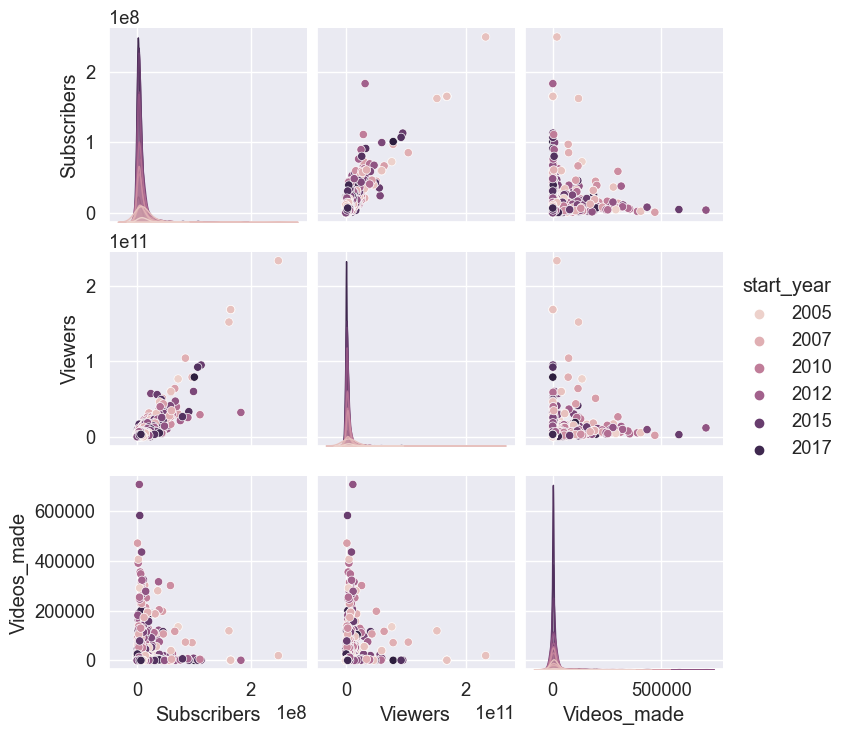

In [39]:
# Pairplot
%matplotlib inline

sns.pairplot(df, vars=['Subscribers', 'Viewers', 'Videos_made'], hue='start_year')
plt.show()

In [40]:
df['start_year']

0       2005
1       2006
2       2006
3       2006
4       2007
        ... 
4329    2014
4330    2015
4331    2006
4332    2006
4333    2017
Name: start_year, Length: 4334, dtype: int32

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


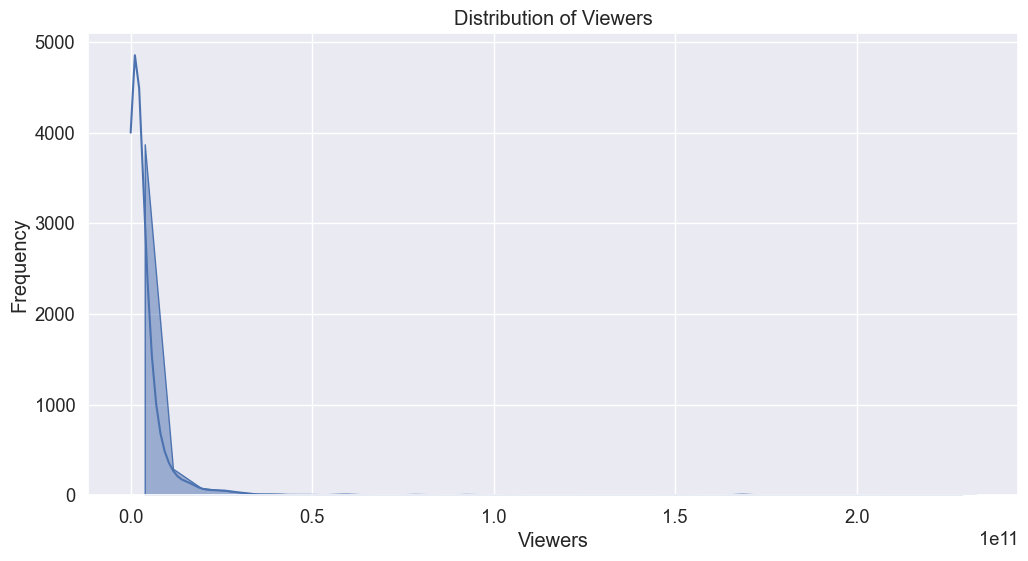

In [41]:
# Distribution of Viewers
%matplotlib inline
plt.figure(figsize=(12, 6))
df['Viewers'] = df['Viewers'].astype(float)  # Convert 'Viewers' to float
sns.histplot(df['Viewers'], bins=30, kde=True, element = 'poly')
plt.title('Distribution of Viewers')
plt.xlabel('Viewers')
plt.ylabel('Frequency')
plt.show()

In [42]:
df[df['Viewers'] == 0]

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second,channel_description_cleaned,channel_description_cleaned_ns
89,hairong zheng,2020,0.0,0,NaN,2018,5,25,12:36:08,12,36,08,nan,nan
93,NollywoodStreams,4520000,0.0,0,Nollywood Streams is your #1 point for excitin...,2013,3,5,11:44:04,11,44,04,Nollywood Streams is your point for exciting N...,Nollywood Streams point exciting Nigerian movi...
144,Family GamesTV,20200000,0.0,0,NaN,2016,1,26,13:57:22,13,57,22,nan,nan
506,Wit Vlogs,215000,0.0,0,"Hi everyone,\n\nNice to see you visit our page...",2017,8,19,03:12:06,03,12,06,Hi everyone Nice to see you visit our page Wit...,Hi everyone Nice see visit page Witvlogs creat...
696,Tatyane Sena,354000,0.0,0,NaN,2014,9,1,01:45:43,01,45,43,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077,KNOWbg,258000,0.0,0,KNOWbg,2017,12,14,03:09:21,03,09,21,KNOWbg,KNOWbg
4109,Bublik,2290000,0.0,0,NaN,2015,11,4,05:08:37,05,08,37,nan,nan
4152,The Evans,118000,0.0,0,Stan Bangtan and ENHYPEN💜🧡,2014,8,2,20:03:32,20,03,32,Stan Bangtan and ENHYPEN,Stan Bangtan ENHYPEN
4230,The Jeremy Kyle Show,1500000,0.0,0,NaN,2015,1,26,15:11:28,15,11,28,nan,nan


In [43]:
print(df['Viewers'].min())
print(df['Viewers'].max())

0.0
232887000000.0


D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


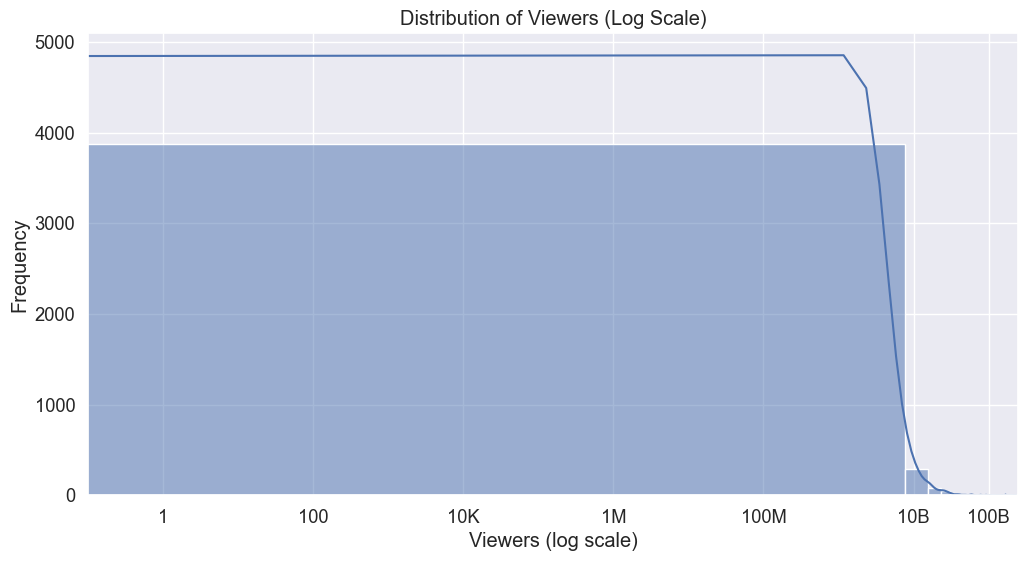

In [44]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df['Viewers'], bins=30, kde=True)
plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.title('Distribution of Viewers (Log Scale)')
plt.xlabel('Viewers (log scale)')
plt.ylabel('Frequency')
plt.xlim(1e-1, 2.5e11)  # Set the x-axis limits to focus on the non-zero range
plt.xticks([1e0, 1e2, 1e4, 1e6, 1e8, 1e10, 1e11], ['1', '100', '10K', '1M', '100M', '10B', '100B'])
plt.show()

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


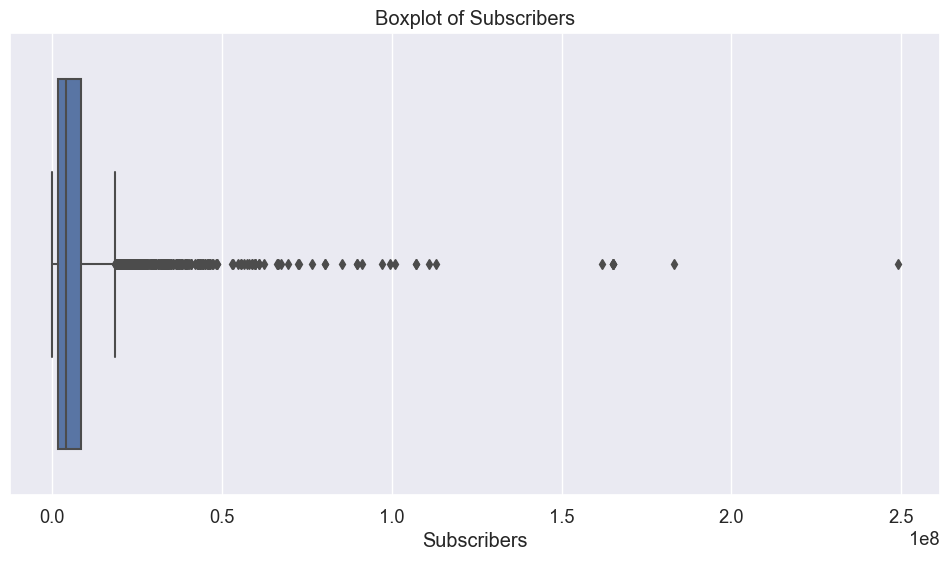

In [45]:
# Boxplot of Subscribers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Subscribers'])
plt.title('Boxplot of Subscribers')
plt.xlabel('Subscribers')
plt.show()

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


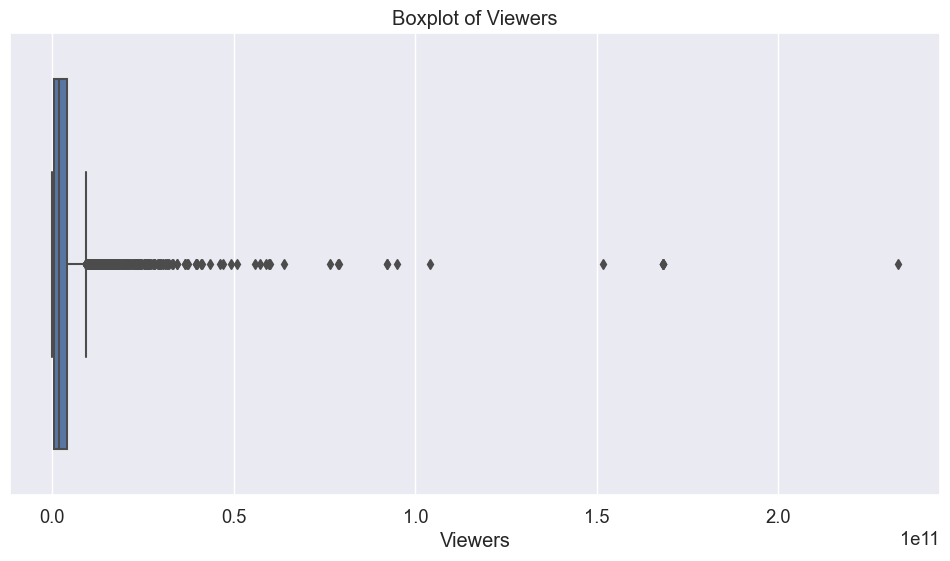

In [46]:
# Boxplot of Viewers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Viewers'])
plt.title('Boxplot of Viewers')
plt.xlabel('Viewers')
plt.show()

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


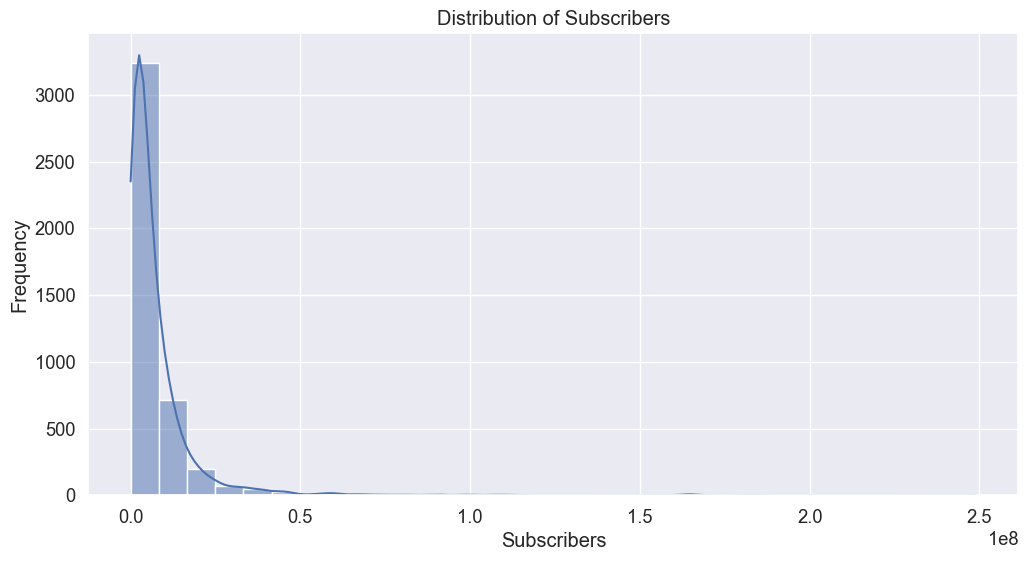

In [47]:
# Subscriber Distribution:
plt.figure(figsize=(12, 6))
sns.histplot(df['Subscribers'], bins=30, kde=True)
plt.title('Distribution of Subscribers')
plt.xlabel('Subscribers')
plt.ylabel('Frequency')
plt.show()

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


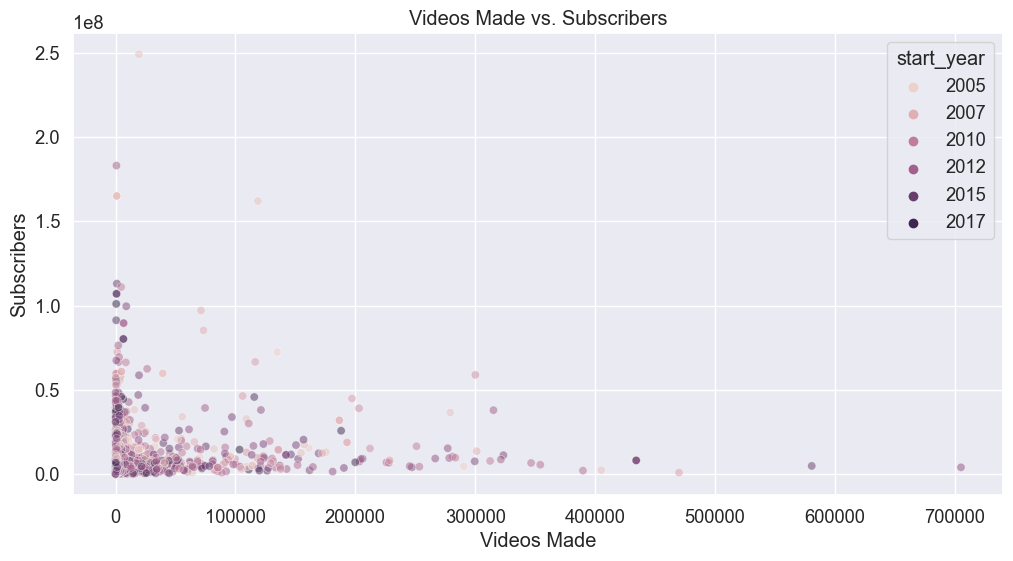

In [48]:
# Videos Made vs. Subscribers

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Videos_made', y='Subscribers', alpha=0.5, hue = 'start_year')
plt.title('Videos Made vs. Subscribers')
plt.xlabel('Videos Made')
plt.ylabel('Subscribers')
plt.show()

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


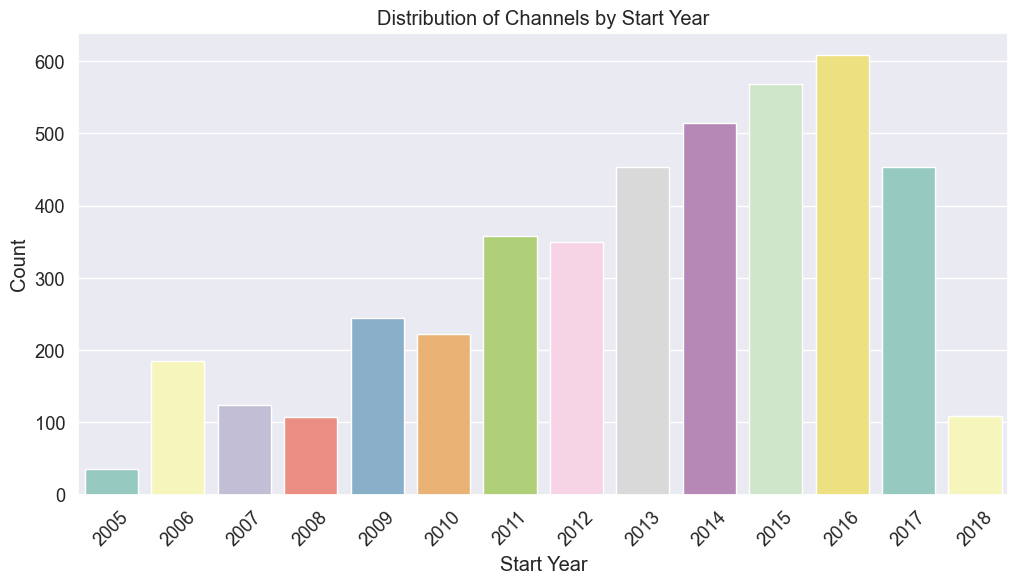

In [49]:
# Start Year Distribution:

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='start_year', palette='Set3')
plt.title('Distribution of Channels by Start Year')
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

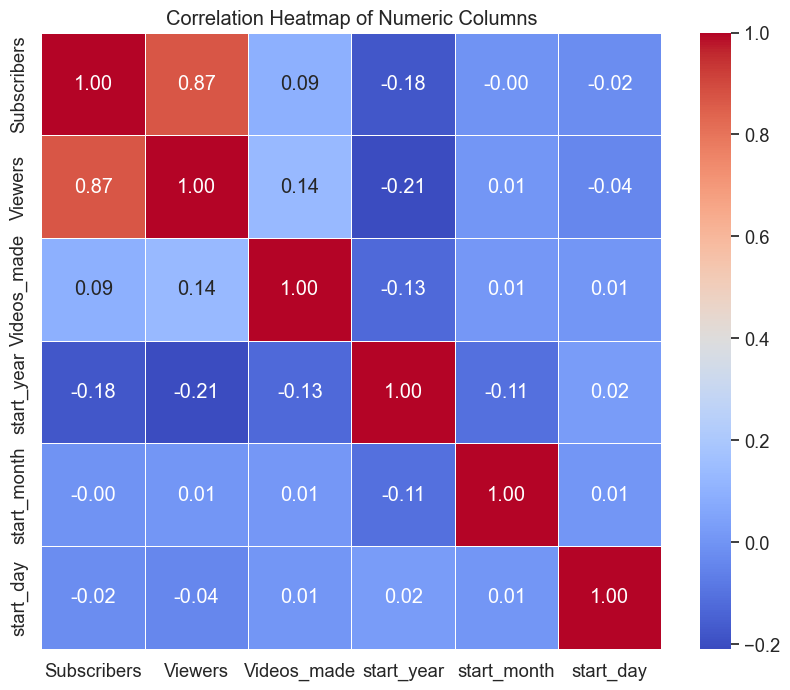

In [50]:
# Correlation plot

numeric_data = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44844 (\N{HANGUL SYLLABLE GGO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.p

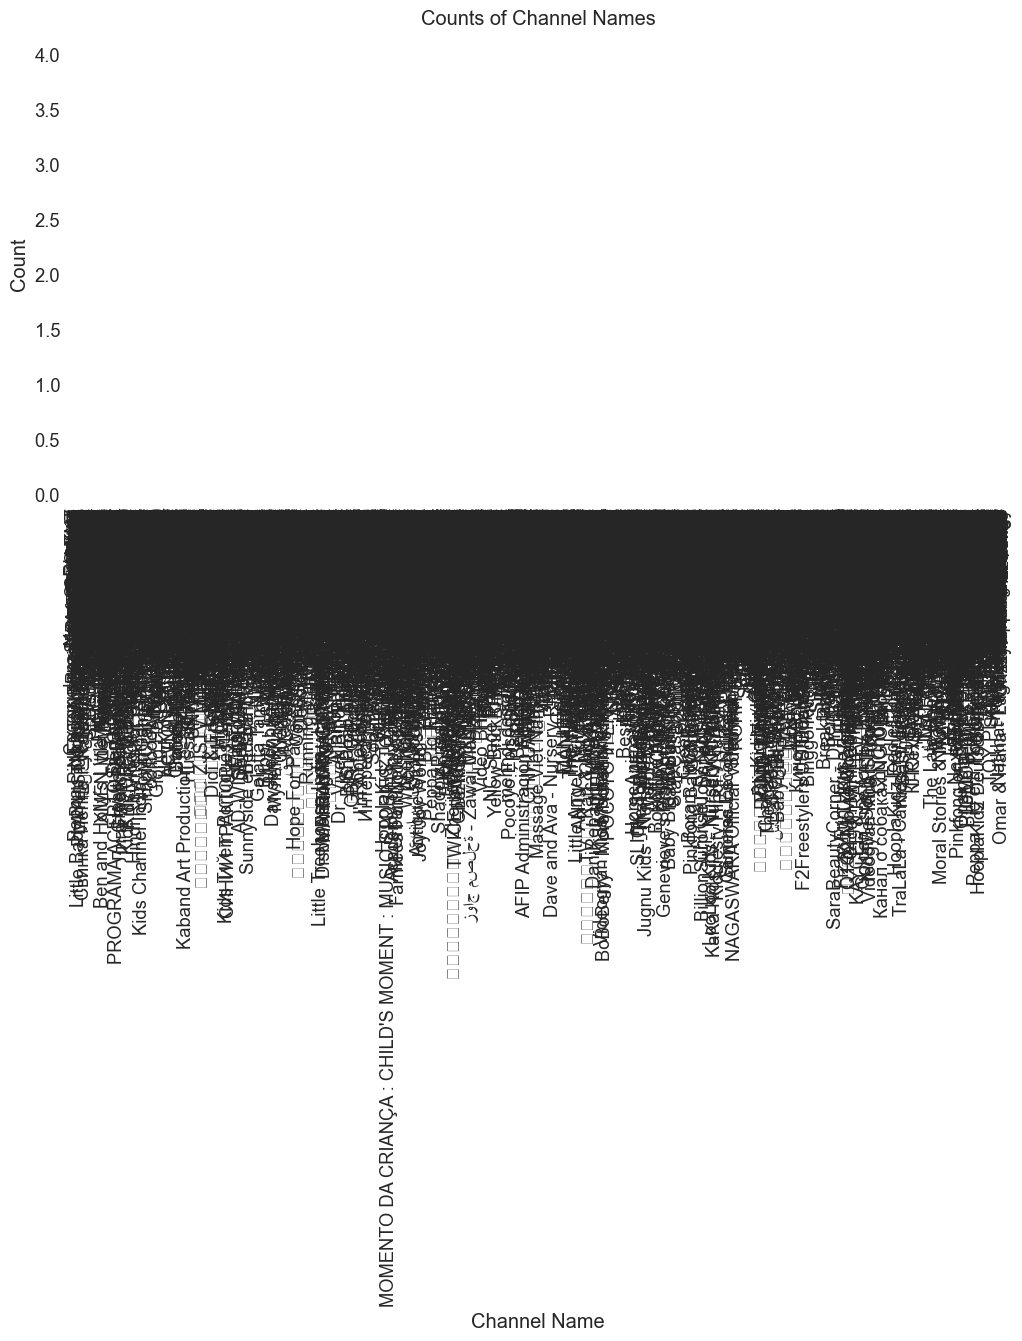

In [51]:
# Bar plot for cat data
plt.figure(figsize=(12, 6))
df['channel_name'].value_counts().plot(kind='bar')
plt.title('Counts of Channel Names')
plt.xlabel('Channel Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

#plt.savefig('channel_name_counts.png', bbox_inches='tight')

#### WORD CLOUD

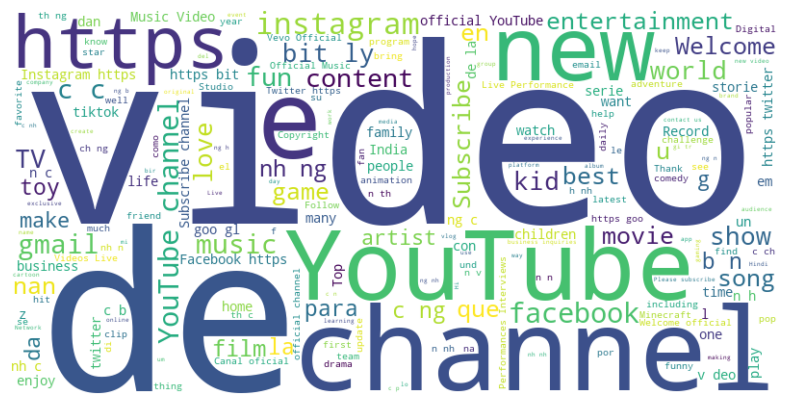

In [52]:

# Combine all titles into a single string
all_titles = ' '.join(df['channel_description_cleaned_ns'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Masters-2023\Machine Learning\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


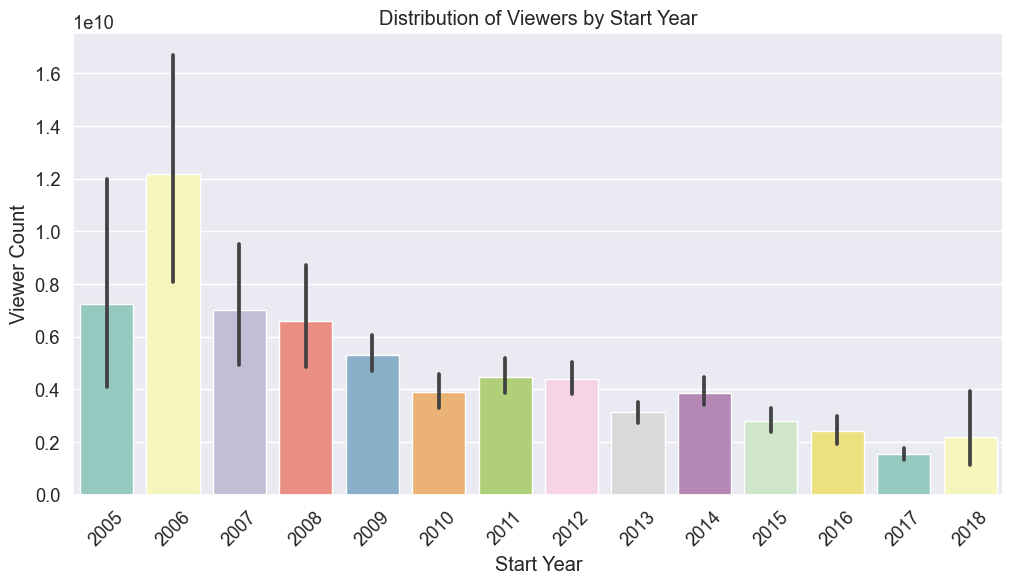

In [53]:
# Viewers across the years
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='start_year', y = 'Viewers', palette='Set3')
plt.title('Distribution of Viewers by Start Year')
plt.xlabel('Start Year')
plt.ylabel('Viewer Count')
plt.xticks(rotation=45)
plt.show()

In [54]:
df

,channel_name,Subscribers,Viewers,Videos_made,channel_description,start_year,start_month,start_day,start_time,start_hour,start_minute,start_second,channel_description_cleaned,channel_description_cleaned_ns
0,Zee TV,72500000,7.649366e+10,134822,"Launched in 1992, ZEE TV is the pioneer of tel...",2005,12,11,06:23:26,06,23,26,Launched in ZEE TV is the pioneer of televisio...,Launched ZEE TV pioneer television entertainme...
1,T-Series,249000000,2.328870e+11,19492,"""Music can change the world"". T-Series is Indi...",2006,3,13,14:27:05,14,27,05,Music can change the world T Series is India s...,Music change world Series India largest Music ...
2,Cocomelon - Nursery Rhymes,165000000,1.682480e+11,1005,"At CoComelon, our primary goal has always been...",2006,9,1,22:18:49,22,18,49,At CoComelon our primary goal has always been ...,CoComelon primary goal always engage families ...
3,SET India,162000000,1.517180e+11,118804,Sony Entertainment Television is one of the le...,2006,9,20,22:24:59,22,24,59,Sony Entertainment Television is one of the le...,Sony Entertainment Television one leading Hind...
4,WWE,97100000,7.877977e+10,71268,WWE on YouTube is your number one spot to catc...,2007,5,11,01:20:02,01,20,02,WWE on YouTube is your number one spot to catc...,WWE YouTube number one spot catch WWE original...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4329,Daniel Shaya,207000,2.834100e+05,18,Канал для взрослых детей 😜 I am Daniel SHAYA.\...,2014,12,31,12:15:20,12,15,20,I am Daniel SHAYA Instagram DanielShaya,Daniel SHAYA Instagram DanielShaya
4330,Mythri Movie Makers,4150000,2.087983e+09,1473,Mythri Movie Makers is a popular Telugu movie ...,2015,5,26,07:14:09,07,14,09,Mythri Movie Makers is a popular Telugu movie ...,Mythri Movie Makers popular Telugu movie produ...
4331,Machinima,11600000,0.000000e+00,0,Machinima is the most notorious purveyor and c...,2006,1,17,01:37:54,01,37,54,Machinima is the most notorious purveyor and c...,Machinima notorious purveyor cultivator fandom...
4332,luisitorey,9510000,1.968355e+09,1122,En este canal hacemos un critica seria a los t...,2006,3,10,14:03:21,14,03,21,En este canal hacemos un critica seria a los t...,En este canal hacemos un critica seria los tem...


In [55]:
#df['channel_description_cleaned_ns'].to_list()

In [56]:
df.to_csv('Cleaned_channel.csv')